# Testing the generative model

We use a Random Forests classifier to compare our generated samples to the real deal

In [65]:
#Importing the libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [66]:
BGV_data = pd.read_csv("processed_data/processed_over2000_BGV_mirror_131mm.csv",header=None,sep='\t')
data = BGV_data.values

### New data generation

We use KDE to generate new data and compare it to the BGV data

In [67]:
#taking away a random subset of the data to generate new samples
from sklearn.cross_validation import train_test_split
X_data, gen_data = train_test_split(data,random_state=0,test_size=0.5)
gen_data.shape

(42219, 11)

In [143]:
%%time
# use grid search to optimize the bandwidth
from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KernelDensity

bw_data = gen_data[np.random.randint(len(gen_data),size=1000),:]
params = {'bandwidth': np.logspace(-4,3,10),
    #'bandwidth': np.logspace(-2,3,20),
          'leaf_size' : np.linspace(100,800,30)
}
grid = GridSearchCV(KernelDensity(), params)
grid.fit(bw_data)
print("best bandwidth: {0}".format(grid.best_estimator_.bandwidth))
print("best leaf_size: {0}".format(grid.best_estimator_.leaf_size))

best bandwidth: 166.81005372000593
best leaf_size: 100.0
CPU times: user 13.5 s, sys: 147 ms, total: 13.6 s
Wall time: 14 s


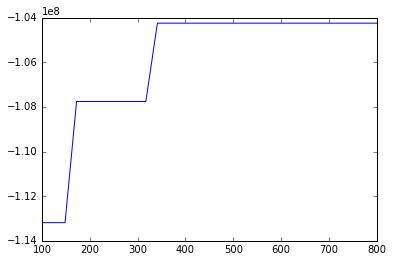

In [142]:
params =[]
score=[]
for point in grid.grid_scores_:
    score.append(point.mean_validation_score)
    params.append(point.parameters['leaf_size'])
    
plt.plot(params, score)

In [108]:
kde = grid.best_estimator_
kde.fit(gen_data)

KernelDensity(algorithm='auto', atol=0, bandwidth=1.0, breadth_first=True,
       kernel='gaussian', leaf_size=46.888888888888886, metric='euclidean',
       metric_params=None, rtol=0)

In [109]:
kde = KernelDensity(bandwidth = grid.best_estimator_.bandwidth, leaf_size=grid.best_estimator_.leaf_size)
kde.fit(gen_data)

KernelDensity(algorithm='auto', atol=0, bandwidth=1.0, breadth_first=True,
       kernel='gaussian', leaf_size=46.888888888888886, metric='euclidean',
       metric_params=None, rtol=0)

In [110]:
X_gen = kde.sample(len(X_data), random_state=0)
X_gen.shape

(42218, 11)

In [111]:
y_data = np.ones((len(X_data),1), dtype=bool)
y_gen = np.zeros((len(X_gen),1), dtype=bool)

X = np.vstack((X_data,X_gen))
y = np.vstack((y_data,y_gen))
y = y.ravel()
print(y)

[ True  True  True ..., False False False]


### Cross-validation

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=0,test_size=0.3)
X_test.shape

(25331, 11)

### Prediction and score

In [113]:
from sklearn.ensemble import ExtraTreesClassifier
ET_class = ExtraTreesClassifier(random_state=14, max_depth=10, n_estimators=100)
ET_class.fit(X_train, y_train)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=10, max_features='auto', max_leaf_nodes=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=14, verbose=0, warm_start=False)

In [114]:
#Prediction
print(X_test.shape)
print(X_train.shape)
y_pred = ET_class.predict(X_test)
print(y_pred.shape)
print(y_test.shape)
ET_class.score(X_test, y_test)

(25331, 11)
(59105, 11)
(25331,)
(25331,)


0.555287987051439

### Keeping the "good" generated points, and feeding them back to the KDE estimator

We are especially interested in events of the form:
```python
y_test[event] = False
y_pred[event] = True
```
Meaning the sample was good enough that the classifier mistook it for the real deal.

In [83]:
#Isolating the "good" samples
ind_good = np.intersect1d(np.argwhere(y_test==False).reshape(-1),np.argwhere(y_pred==True).reshape(-1))
print(ind_good.shape)
X_good = X_test[ind_good,:]
X_ini = X_good

(8772,)


In [ ]:
#same procedure as before
X_good = X_ini
X_data, gen_data = train_test_split(data,random_state=0,test_size=0.3)
for i in range(0,10):
    gen_data = np.vstack((gen_data, X_good))
    print(len(gen_data))

    kde.fit(gen_data)
    X_gen = kde.sample(len(X_data)).astype(int), random_state=14)

    y_data = np.ones((len(X_data),1), dtype=bool)
    y_gen = np.zeros((len(X_gen),1), dtype=bool)

    X = np.vstack((X_data,X_gen))
    y = np.vstack((y_data,y_gen)).ravel()

    X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=None,test_size=0.3)

    ET_class.fit(X_train, y_train)
    y_pred = ET_class.predict(X_test)

    ind_good = np.intersect1d(np.argwhere(y_test==False).reshape(-1),np.argwhere(y_pred==True).reshape(-1))
    print(ind_good.shape)
    X_good = X_test[ind_good,:]

In [ ]:
ET_class.score(X_test, y_test)

In [ ]:
X_data, gen_data = train_test_split(data,random_state=0,test_size=0.3)
X_gen = kde.sample(20000, random_state=14)
y_data = np.ones((len(X_data),1), dtype=bool)
y_gen = np.zeros((len(X_gen),1), dtype=bool)

X = np.vstack((X_data,X_gen))
y = np.vstack((y_data,y_gen)).ravel()

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=None,test_size=0.3)

ET_class.fit(X_train, y_train)
y_pred = ET_class.predict(X_test)
ET_class.score(X_test, y_test)

In [16]:
np.linspace(100,400,20)

array([ 100.        ,  115.78947368,  131.57894737,  147.36842105,
        163.15789474,  178.94736842,  194.73684211,  210.52631579,
        226.31578947,  242.10526316,  257.89473684,  273.68421053,
        289.47368421,  305.26315789,  321.05263158,  336.84210526,
        352.63157895,  368.42105263,  384.21052632,  400.        ])